# Imports

In [1]:
#%run /Home/siv30/wad005/master/GRB/xspec/FERMI/fermi_functions.ipynb
%run /Users/andreas/phys/master/GRB/xspec/FERMI/fermi_functions.ipynb

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!


/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "


FERMI functions loaded successfully!


/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re, sys

from astropy.io import fits, ascii
from astropy.time import Time
from stingray import Lightcurve as LC
from stingray import CrossCorrelation
from dateutil import parser

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
from gbm.data.primitives import EventList
%matplotlib inline

CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# Notes on GRB

# Paths

In [3]:
GRB_id = "GRB190606"
bn='bn190606080' # not found in finder folder, but found in terminal ?
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open
print(data_dir)

/Users/andreas/phys/master/FERMI/data//bn190606080/


# Find the angle of the GRB wrt the GBM units

In [7]:
fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v02.fit' #v02.fit instead of v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

glg_trigdat_all_bn190606080_v02.fit
581478912.776248
['n0', 'n1', 'n3', 'n5']


In [8]:
grb_ra, grb_dec = 76.561, -0.638 #Reported by IPN

In [10]:
all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function

#Very good inclination for the first two instruments.

n5 17.683
b0 18.854
n1 41.76
n3 51.236
n2 53.473
n0 57.119
n4 65.365
n6 88.932
n9 102.07
n7 109.75
na 115.411
n8 128.288
b1 161.146
nb 162.502


# Find temporal offset between GBM trigger time and others

from gbm.time import Met
import datetime

# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?
print(t0METgbm)
print(tshift)
print(t0METgbm-tshift)


ToF_Fermi_ASIM = -0.0008 #light travel time in seconds
ToF_KW_ASIM = 0.7142 
str_t0KW = '2020-12-27T15:14:06.705' #T0 for KW
t0METKW = t0METgbm.from_iso(str_t0KW) #Converting T0 KW to T0 met

#Q: Why are we adding both ToF? Double check this
t0MET = t0METKW.add(ToF_KW_ASIM+ToF_Fermi_ASIM)  # To add seconds
tshift = t0MET - t0METgbm
print(tshift) #shift between KW trigger and GBM trigger is <4ms 
print(t0METgbm-tshift)


#  Extract data from selected unit(s)+

In [11]:
unit = all_dets[idx_sort_angsep][1] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v03.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b0


In [12]:
tte = TTE.open(fn_tte)
bint = 0.002 # 2ms binning

# certain useful properties are easily accessible
print("GTI: {}".format(tte.gti))
print("Trigger time: {}".format(tte.trigtime))
print("Time Range: {}".format(tte.time_range))
print("Energy Range: {}".format(tte.energy_range))
#print('# of Energy Channels: {}'.format(tte.numchan))

GTI: [[-133.3624279499054, 481.0503239631653]]
Trigger time: 581478912.776248
Time Range: (-133.3624279499054, 481.0503239631653)
Energy Range: (113.24812, 50000.0)


# KW lc

0.512


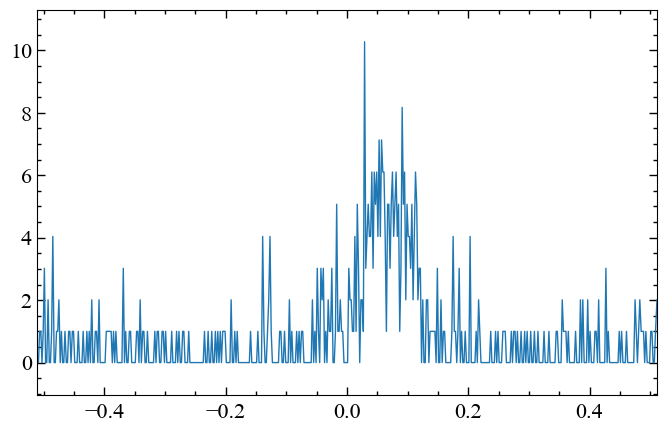

In [13]:
kw_filename = "GRB190606A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# FERMI lc

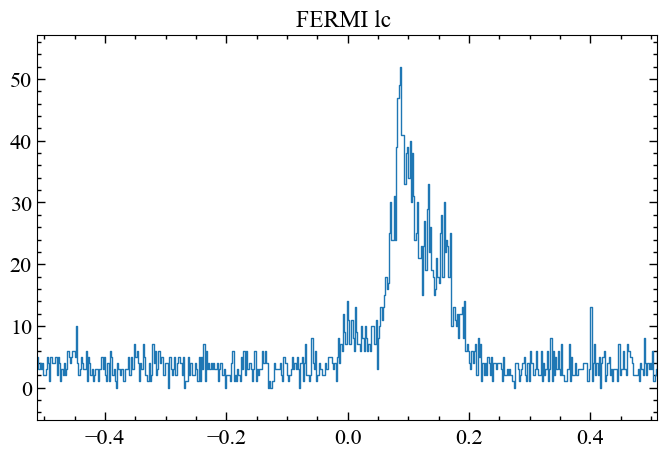

In [14]:
tus = tte.data.time

hist = np.histogram(tus,bins=np.append(kw_bin_lo,kw_bin_hi[-1]))
fermiCounts,fermiEdges = hist[0],hist[1]

plt.step(x=fermiEdges[:-1],y=fermiCounts,where="post")
plt.title("FERMI lc ")
plt.show()

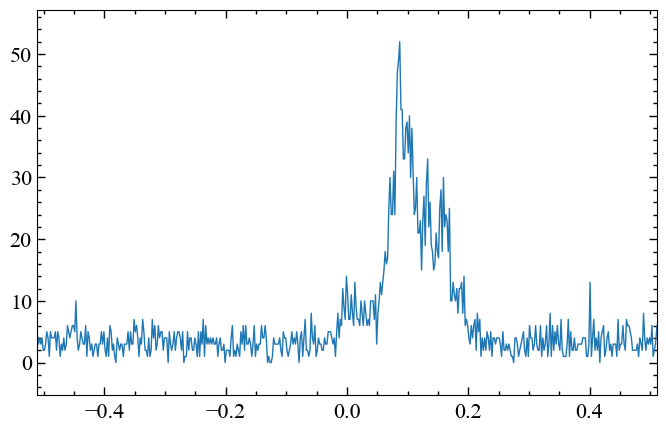

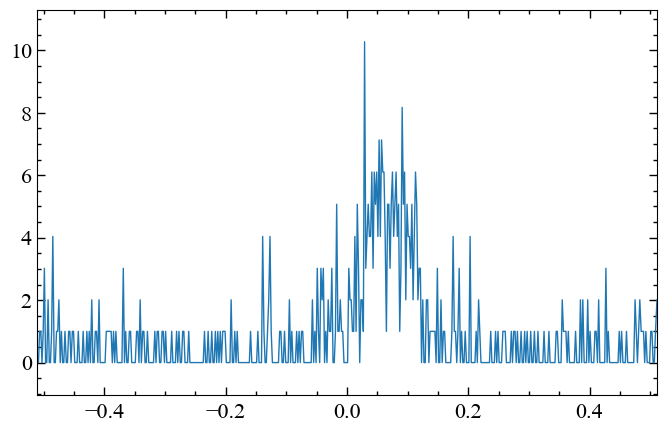

In [15]:
fermi_lc = LC(time=np.round(kw_bin_lo+binsize/2, 3), counts=fermiCounts, skip_checks=True,dt=binsize)
fermi_lc.plot()
kw_lc.plot()

# Overlapping lc's

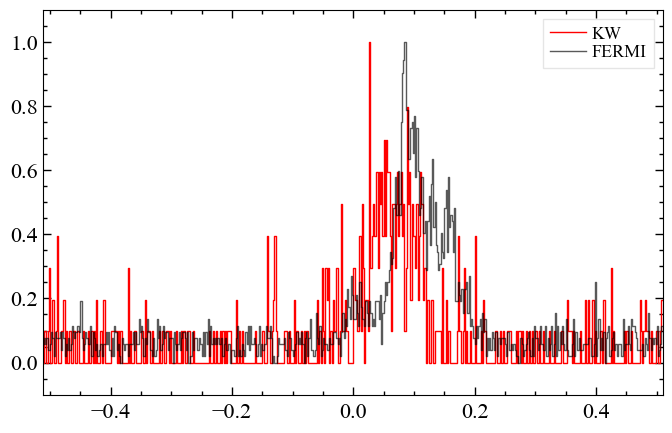

In [17]:
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),label='KW',c='red')
plt.step(x=kw_bin_lo,y=fermiCounts/max(fermiCounts),label='FERMI',c='black',alpha=0.65)
plt.legend()
plt.show()

# CC
    Looks good from the overlapping LC's.
    CC returns tlagg = 0.00 s!
    
    Find out why my own crossCorrolate function return -0.008 s (4 bins)
    Shift the fermiLC by 4 bins to see if its better.
        >> using different bins might be the reason
        
        >> Tried to shift, and the result is not good at all
        Seems like the original tte array is well aligned with KW
    

Total lagg (s):  -0.042


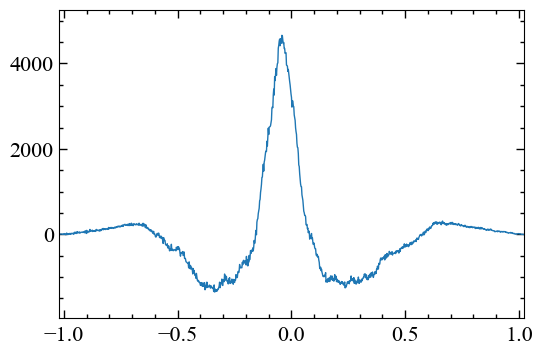

<AxesSubplot:>

In [18]:
CC = CrossCorrelation(kw_lc,fermi_lc,mode="full")
CClagg=CC.time_shift
tlagg = CClagg
print("Total lagg (s): ", tlagg)
CC.plot()

# New TTE object

In [56]:
tlagg = -0.042
newTTE = createNewTTE(oldTTEObj=tte,
                      tlagg=tlagg,
                      binsize=bint,
                      unit=unit,
                      obj=GRB_id,
                      grb_ra=grb_ra,
                      grb_dec=grb_dec)

phaii = newTTE.to_phaii(bin_by_time,bint)

tte shifted by -0.042
new TTE object created


# Checking TSTART/STOP

In [25]:
tte.trigtime,newTTE.trigtime

(581478912.776248, 581478912.7342479)

In [42]:
print('Diff after tlagg in us: ',(581478912.776248-581478912.7342479)*1e6)

Diff after tlagg in us:  42000.05531311035


In [54]:
new_TSTART,new_TSTOP =  581478912.7343038, 581478912.7982138
print('Exposure (new): ', new_TSTOP-new_TSTART)

Exposure (new):  0.06391000747680664


In [55]:
old_TSTART,old_TSTOP = 581478912.7764261,581478912.840142
print('Exposure (old): ', old_TSTOP-old_TSTART)

Exposure (old):  0.06371593475341797


In [52]:
print('Diff in us (new): ',(new_TSTART-newTTE.trigtime)*1e6)

Diff in us (new):  55.909156799316406


In [51]:
print('Diff in us (old): ',(old_TSTART-tte.trigtime)*1e6)

Diff in us (old):  178.0986785888672


In [53]:
#Conclusion is that trigtime is shifting correctly the TSTART/STOP values in the HEADER
# The difference between TSTART and trigtime is floating point error, coming from the selection mechanism when when choosing scr_time

# TODO:
    Go into the doc for generation for fits files and see how they are declaring the TSTART and TSTOP from the trigtime
    >> The keys are not set specifically, but it seems self.trigtime is used
    >> Can generate the old and new tte to see if it changes anything. The trigtime is shifted, so it should be changend

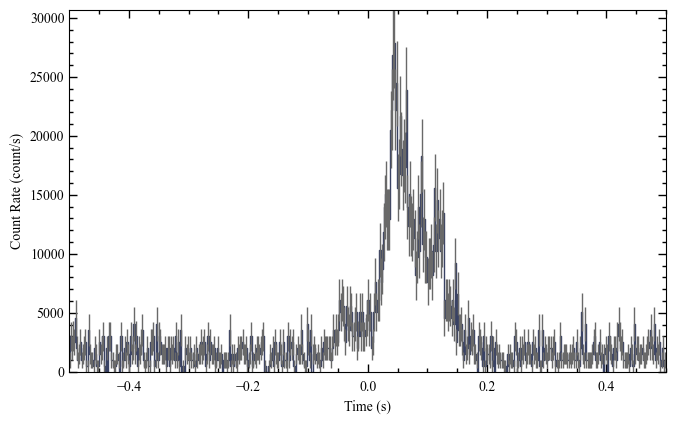

In [57]:
erange = (150, 4e4) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange) #lightcurve binned by the given bint?
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,.5)

In [59]:
# Fit background
bkgd_times = [(-100, -5), (100,200)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

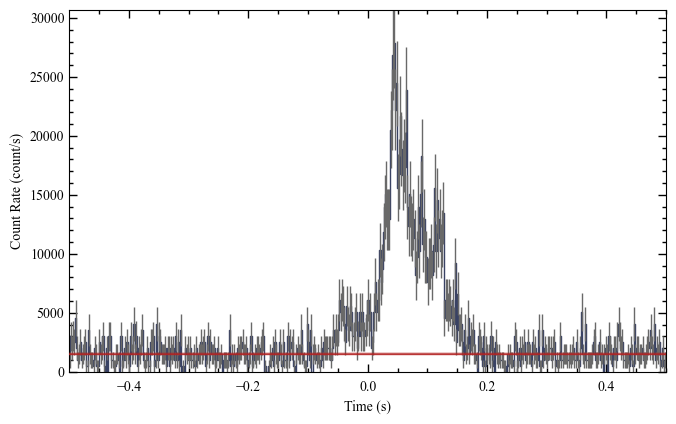

In [60]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-0.5,0.5)
lcplot.xlim = view_range

In [61]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([  2.9010659 ,   7.97477427,   8.71951133,  10.45104285,
        10.94833424,   9.03175903,  10.32494505,  13.30421367,
        15.82627931,  15.6710011 ,  13.96840761,  17.36051974,
        17.628791  ,  20.28290806,  22.97902403,  23.54480127,
        21.36907025,  19.73425409,  20.83848658,  22.10705209,
        21.85231494,  20.04149501,  19.24875795,  16.06190303,
        16.45973465,  21.13369101,  23.06429676,  21.47968854,
        18.85559166,  17.76635227,  18.86532032,  20.12349159,
        22.76459304,  21.2216914 ,  23.74017084,  23.94666363,
        26.35498548,  29.53413991,  33.18535202,  35.00187158,
        28.02635248,  28.17509902,  38.37761513,  52.91963391,
        51.15785881,  49.11353234,  42.0765796 ,  41.41426179,
        43.46004871,  58.93787029,  67.85611141,  79.63375278,
        83.77613351,  87.71578067,  57.76929727,  61.21935378,
        95.51056077, 147.95039403, 145.42218408, 207.48039486,
       220.81823788, 236.17072752, 237.18575589, 268.51

In [62]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

Normalised residuals: mean= 0.00122  std= 1.03
NormaltestResult(statistic=5522.97556168653, pvalue=0.0)


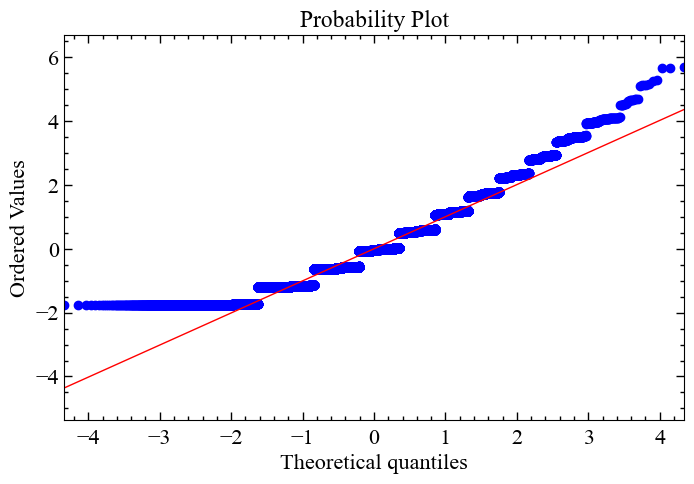

In [63]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

# Extracting spectra

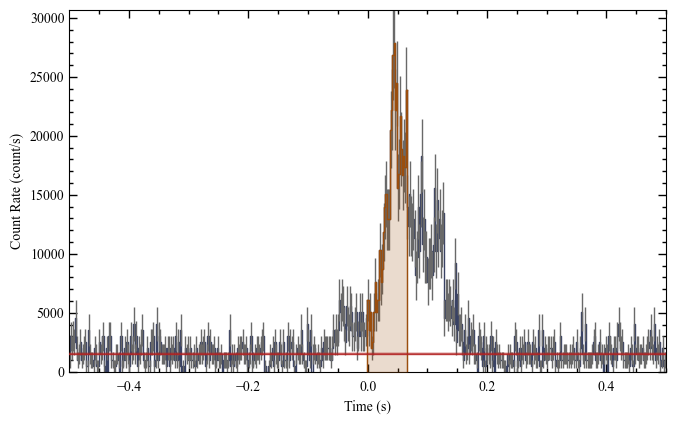

In [64]:
src_time = (0.00,0.064) #Need around 100ms expose for this burst
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

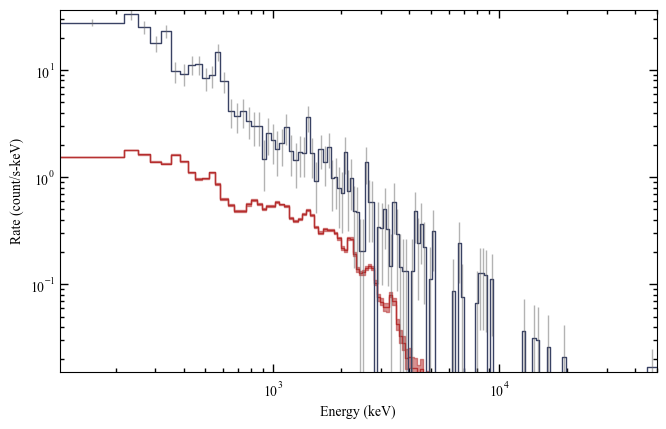

In [65]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = newTTE.to_spectrum(time_range=src_time) #doing it first for the newTTE
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

In [66]:
# Extract the corresponding PHA from source and bkg files
pha = newTTE.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

In [67]:
# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
#bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")

fparkey GRB190606_b0.rsp GRB190606_b0.pha+2 RESPFILE
